# Import Libraries

In [1]:
import healpy as hp
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

In [2]:
from src.info_extractor import InfoExtractor
from src.patch_analyser import PatchAnalyser
from src.fullsky_analyser import FullSkyAnalyser
from analysis import KappaAnalyser
from src.patch_processor import PatchProcessor
from src.utils import load_config, filter_config, setup_logging

# Setup the environment

In [3]:
workdir = Path("/lustre/work/akira.tokiwa/Projects/LensingSSC")
config_file = workdir / "configs" / "config_default.yaml"
sample_dir = workdir / "data" / "tiled" / "proc2048_nc1024_size625_nsteps60_s401_10tiled"

In [4]:
config = load_config(config_file)
setup_logging()

In [5]:
filtered_config_pp = filter_config(config, PatchProcessor)
pp = PatchProcessor(**filtered_config_pp)

filtered_config_pa = filter_config(config, PatchAnalyser)
pa = PatchAnalyser(pp, **filtered_config_pa)

filtered_config_fsa = filter_config(config, FullSkyAnalyser)
fsa = FullSkyAnalyser(**filtered_config_fsa)

ka = KappaAnalyser(sample_dir, pa, fsa)

2024-10-13 08:43:06,898 - INFO - Initialized PatchProcessor with npatch=273, patch_size_deg=10.0, xsize=2048
2024-10-13 08:43:06,899 - INFO - Initializing FlatPatchAnalyser with nbin=15, lmin=300, lmax=3000
2024-10-13 08:43:06,899 - INFO - FullSkyAnalyser initialized with nside=8192, nbin=15, lmin=300, lmax=3000
2024-10-13 08:43:06,905 - INFO - Output directories created


In [9]:
# ka.analyse()

# Sample run

In [11]:
patch_kappa_path = ka.patch_kappa_paths[0]
tmp_kappa_patches = np.load(patch_kappa_path)
tmp_snr_paths = ka._filter_paths_by_input(ka.patch_snr_paths, patch_kappa_path)
patch_snr_path = tmp_snr_paths[0]
fname = Path(patch_snr_path).name.replace('patches', 'analysis')
snr_patches = np.load(patch_snr_path)
data = ka.pa.process_patches(tmp_kappa_patches, snr_patches)

In [23]:
# sk0, sk1, sk2, kur0, kur1, kur2, kur3 are scalars
# all the other values are the same length: pa.nbin
# The order of the values is equilateral, isosceles, squeezed, clkk,
#            sk0, sk1, sk2, kur0, kur1, kur2, kur3,
#            pdf_vals, peaks, minima, v0, v1, v2

# separate the data
equilateral = data[:, pa.nbin * 0:pa.nbin * 1]
isosceles = data[:, pa.nbin * 1:pa.nbin * 2]
squeezed = data[:, pa.nbin * 2:pa.nbin * 3]
clkk = data[:, pa.nbin * 3:pa.nbin * 4]
sk0 = data[:, pa.nbin * 4]
sk1 = data[:, pa.nbin * 4 + 1]
sk2 = data[:, pa.nbin * 4 + 2]
kur0 = data[:, pa.nbin * 4 + 3]
kur1 = data[:, pa.nbin * 4 + 4]
kur2 = data[:, pa.nbin * 4 + 5]
kur3 = data[:, pa.nbin * 4 + 6]
pdf_vals = data[:, pa.nbin * 4 + 7:pa.nbin * 5 + 7]
peaks = data[:, pa.nbin * 5 + 7:pa.nbin * 6 + 7]
minima = data[:, pa.nbin * 6 + 7:pa.nbin * 7 + 7]
v0 = data[:, pa.nbin * 7 + 7:pa.nbin * 8 + 7]
v1 = data[:, pa.nbin * 8 + 7:pa.nbin * 9 + 7]
v2 = data[:, pa.nbin * 9 + 7:pa.nbin * 10 + 7]

In [14]:
global_std = np.std(snr_patches)

In [15]:
from lenstools import ConvergenceMap
from astropy import units as u

patch_pixels = tmp_kappa_patches[0]
patch_snr_pixels = snr_patches[0]

# Process kappa (convergence) map
conv_map = ConvergenceMap(patch_pixels, angle=pa.patch_size * u.deg)
equilateral, isosceles, squeezed = pa._compute_bispectrum(conv_map)
clkk = pa._compute_power_spectrum(conv_map)
sk0, sk1, sk2, kur0, kur1, kur2, kur3 = pa._compute_moments(conv_map, global_std)

# Process SNR map
snr_map = ConvergenceMap(patch_snr_pixels/global_std, angle=pa.patch_size * u.deg)
pdf_vals = pa._compute_pdf(snr_map)
peaks = pa._compute_peak_statistics(snr_map, is_minima=False)
minima = pa._compute_peak_statistics(snr_map, is_minima=True)
v0,v1,v2 = pa._compute_minkowski_functionals(snr_map)

# Check the output files

In [13]:
sample_path = "/lustre/work/akira.tokiwa/Projects/LensingSSC/data/bigbox/rfof_proc131072_nc6144_size3750_nsteps60lin_ldr0_rcvfalse_fstnone_pnf2_lnf2_s100_dhf1.0000_tiled0.20_fll_elllim_10000_npix_8192_rfofkdt_8/analysis_patch/analysis_zs0.5_s100_oa10_noiseless_sl2.npy"

In [14]:
data = np.load(sample_path)

In [20]:
data[0][60:]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.23447138e-02,  3.59265983e-01,  6.05554044e-01,  4.24372971e-01,
        2.16456816e-01,  1.15095876e-01,  5.78280352e-02,  3.03397067e-02,
        1.70407742e-02,  1.03049176e-02,  6.39613997e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.68842869e-03,
        8.52656439e-02,  3.36841524e-01,  4.54187304e-01,  3.73142719e-01,
        2.36380011e-01,  1.57868072e-01,  9.53962207e-02,  6.83813617e-02,
        3.88338603e-02,  2.70148590e-02,  0.00000000e+00,  8.59303400e-04,
        8.59303400e-04,  8.59303400e-04,  1.71860680e-03,  1.54674612e-02,
        3.78093496e-02,  1.77875802e-01,  5.71436763e-01,  8.81645262e-01,
        1.86468840e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  9.98643637e-01,  9.19117928e-01,  6.29596472e-01,
        3.42945814e-01,  

In [22]:
sample_path = "/lustre/work/akira.tokiwa/Projects/LensingSSC/output/patch_stats_bigbox_oa10_noiseless_sl2.npy"

In [23]:
data = np.load(sample_path, allow_pickle=True).item()

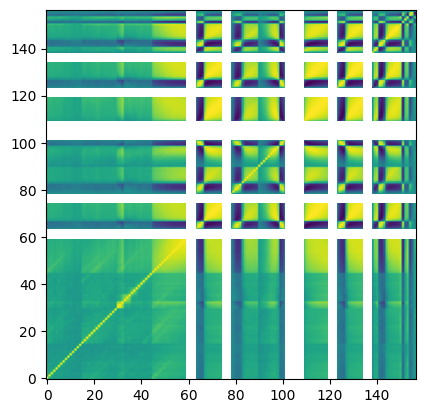

In [26]:
plt.imshow(data[0.5]["corr"], origin="lower", vmin=-1, vmax=1)